### First, build a simple linear regression


# To change: add past 22 day window; try predicting log(return)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("ivv_cleaned.csv")
df.head()

,Unnamed: 0,date,low,high,close,volume,open,close-open,close-open_%of_close,high-low,high-low_%of_close
0,0,20000519,140.25000,142.65625,140.68750,775500,142.65625,-1.96875,-0.013994,2.40625,0.017104
1,1,20000522,136.81250,140.59375,139.81250,1850599,140.59375,-0.78125,-0.005588,3.78125,0.027045
2,2,20000523,137.68750,140.21875,137.68750,373900,140.21875,-2.53125,-0.018384,2.53125,0.018384
3,3,20000524,136.65625,140.06250,139.75000,400300,137.75000,2.00000,0.014311,3.40625,0.024374
4,4,20000525,137.87500,140.93750,138.46875,69600,140.03125,-1.56250,-0.011284,3.06250,0.022117


In [2]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)
#since we are using day T's info to predict day T+1's price, need to change the date ranges of X and y
X = df[['low','high','close','open','close-open','close-open_%of_close','high-low',
        'high-low_%of_close']].loc[0:4555]
next_day_price = df['close'].loc[1:4556].reset_index()
ret = next_day_price/(X['close'].reset_index())-1
ret =ret['close']
y = ret

In [3]:
#split X_train, X_test; y_train, y_test
X_train = X.head(3000)
X_test = X.loc[3000:]
y_train = y.head(3000)

In [4]:
reg.fit(X_train,y_train) 

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [5]:
y_train_hat = reg.predict(X_train)

In [6]:
port_train = X_train
s = pd.DataFrame(y_train_hat)
port_train = pd.concat([X_train, s[0:3000]],axis=1)
#port_train.rename(columns={0:'predicted'}, inplace=True)
port_train['predict%'] = y_train_hat

In [7]:
#> 0.001:strong buy, 2
#> 0.0003: buy, 1
#<-0.01:strong sell, -2
#<-0.005: sell, -1
port_train['action_level'] = 0
port_train.head()

,low,high,close,open,close-open,close-open_%of_close,high-low,high-low_%of_close,0,predict%,action_level
0,140.25000,142.65625,140.68750,142.65625,-1.96875,-0.013994,2.40625,0.017104,-0.000233,-0.000233,0
1,136.81250,140.59375,139.81250,140.59375,-0.78125,-0.005588,3.78125,0.027045,-0.002696,-0.002696,0
2,137.68750,140.21875,137.68750,140.21875,-2.53125,-0.018384,2.53125,0.018384,0.000298,0.000298,0
3,136.65625,140.06250,139.75000,137.75000,2.00000,0.014311,3.40625,0.024374,-0.003053,-0.003053,0
4,137.87500,140.93750,138.46875,140.03125,-1.56250,-0.011284,3.06250,0.022117,-0.000423,-0.000423,0


In [8]:
#find quantiles of the predict%
strongbuy = port_train['predict%'].quantile(0.75)
buy = port_train['predict%'].quantile(0.5)
sell = port_train['predict%'].quantile(0.4)
strongsell = port_train['predict%'].quantile(0.2)

In [9]:
strongbuy

0.0007881759662167255

In [10]:
for i in range(1,len(port_train)):
    if port_train.loc[i,'predict%'] >= strongbuy:
        port_train.loc[i, 'action_level'] = 2
    elif port_train.loc[i,'predict%'] >= buy:
        port_train.loc[i, 'action_level'] = 1
    elif port_train.loc[i,'predict%'] >= strongsell and port_train.loc[i,'predict%'] < sell:
        port_train.loc[i, 'action_level'] = -1
    elif port_train.loc[i,'predict%'] < strongsell:
        port_train.loc[i, 'action_level'] = -2

In [11]:
print(port_train['action_level'].unique())

[ 0 -2  1 -1  2]


In [12]:
#portfolio starts at day 0 with 100,000 cash
port_train['action'] = 0
port_train['cash'] = 100000
port_train['#of_share'] = 0
port_train['tot_value'] = 100000

In [13]:
def rule(port_train):
    for i in range(1,len(port_train)-1):

        if port_train.loc[i-1, 'action_level'] == 0:
            pass

        elif port_train.loc[i-1, 'action_level'] == 2:
            #then will buy or sell at day i+1, assuming at the open price of day i+1
            action_price = port_train.loc[i, 'open']
            #buy as much as possible
            port_train.loc[i, 'action'] = port_train.loc[i-1, 'cash']//action_price
            #on day i+1, cash will decrease, #of shares will increase


        elif port_train.loc[i-1, 'action_level'] == 1:
            action_price = port_train.loc[i, 'open']
            #buy half the maximum possible share
            port_train.loc[i, 'action'] = port_train.loc[i-1, 'cash']//action_price//2

        elif port_train.loc[i-1, 'action_level'] == -2:
            action_price = port_train.loc[i, 'open']
            #sell as much as possible, if on day i, # of shares held is possitive
            if port_train.loc[i-1, '#of_share'] > 0:
                port_train.loc[i, 'action'] = -port_train.loc[i-1, '#of_share']
            else:
                pass

        elif port_train.loc[i-1, 'action_level'] == -1:
            action_price = port_train.loc[i, 'open']
            #sell half of the shares at hand
            if port_train.loc[i-1, '#of_share'] > 0:
                port_train.loc[i, 'action'] = -port_train.loc[i-1, '#of_share']//2
            else:
                pass

        port_train.loc[i, '#of_share'] = port_train.loc[i, 'action'] + port_train.loc[i-1, '#of_share']
        port_train.loc[i, 'cash'] = port_train.loc[i-1, 'cash'] - port_train.loc[i, 'action'] * port_train.loc[i, 'open']
        port_train.loc[i, 'tot_value'] = port_train.loc[i,'cash'] + port_train.loc[i,'#of_share']*port_train.loc[i,'close']
        port_train.loc[len(port_train)-1, 'tot_value'] = port_train.loc[len(port_train)-2,'tot_value']
        port_train.loc[len(port_train)-1, 'cash'] = port_train.loc[len(port_train)-2,'cash']  
    return port_train

In [14]:
port_train = rule(port_train)

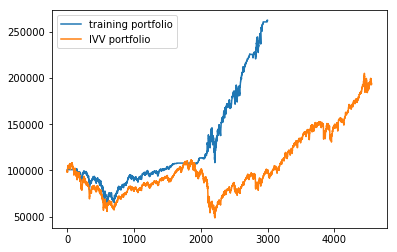

In [15]:
passive_port = df['close']*100000/port_train.loc[0,'close']
df_train_compare = pd.concat([port_train['tot_value'],passive_port],axis=1)
df_train_compare.rename(columns={'tot_value':'training portfolio','close':'IVV portfolio'},inplace=True)
df_train_compare.plot()

## to do: add hitogram of buy or sell actions

## plot the test result

In [16]:
y_test_hat = reg.predict(X_test)
s_test = pd.DataFrame(y_test_hat)

In [17]:
len(y_test_hat)==len(s_test)

True

In [18]:
y_test_hat

array([-0.00021058, -0.00047303, -0.00126117, ..., -0.00550789,
       -0.00497601, -0.00736631])

In [19]:
port_test = pd.concat([X_test.reset_index(), s_test],axis=1)

In [20]:
port_test.rename(columns={0:'predicted'}, inplace=True)

In [ ]:
port_test

In [21]:
port_test['predict%'] = y_test_hat
port_test['action_level'] = 0
port_test.head()

,index,low,high,close,open,close-open,close-open_%of_close,high-low,high-low_%of_close,predicted,predict%,action_level
0,3000,137.32001,138.14000,137.78999,137.42999,0.36000,0.002613,0.81999,0.005951,-0.000211,-0.000211,0
1,3001,139.03999,139.73000,139.73000,139.16000,0.57000,0.004079,0.69001,0.004938,-0.000473,-0.000473,0
2,3002,139.31000,140.82001,140.66000,139.39999,1.26001,0.008958,1.51001,0.010735,-0.001261,-0.001261,0
3,3003,140.31770,141.28999,140.91000,141.11000,-0.20000,-0.001419,0.97229,0.006900,-0.000381,-0.000381,0
4,3004,140.00000,140.72000,140.28000,140.62000,-0.34000,-0.002424,0.72000,0.005133,-0.000042,-0.000042,0


In [22]:
for i in range(0,len(port_test)-1):
    if port_test.loc[i,'predict%'] >= strongbuy:
        port_test.loc[i, 'action_level'] = 2
    elif port_test.loc[i,'predict%'] >= buy:
        port_test.loc[i, 'action_level'] = 1
    elif port_test.loc[i,'predict%'] >= strongsell and port_test.loc[i,'predict%'] < sell:
        port_test.loc[i, 'action_level'] = -1
    elif port_test.loc[i,'predict%'] < -strongsell:
        port_test.loc[i, 'action_level'] = -2

In [23]:
print(port_test['action_level'].unique())

[-1 -2  1  0]


In [24]:
port_test['action'] = 0
port_test['cash'] = 100000
port_test['#of_share'] = 0
port_test['tot_value'] = 100000

In [25]:
port_test = rule(port_test)

In [30]:
port_test.tail()

,index,low,high,close,open,close-open,close-open_%of_close,high-low,high-low_%of_close,predicted,predict%,action_level,action,cash,#of_share,tot_value
1551,4551,277.66000,278.95999,277.89001,278.89001,-1.00000,-0.003599,1.29999,0.004678,-0.004968,-0.004968,-2,0.0,97836.5903,0.0,97836.5903
1552,4552,272.23001,276.76001,274.10001,276.60001,-2.50000,-0.009121,4.53000,0.016527,-0.006611,-0.006611,-2,0.0,97836.5903,0.0,97836.5903
1553,4553,272.64001,274.39999,273.47000,273.50000,-0.03000,-0.000110,1.75998,0.006436,-0.005508,-0.005508,-2,0.0,97836.5903,0.0,97836.5903
1554,4554,271.03000,275.71259,271.12000,274.07999,-2.95999,-0.010918,4.68259,0.017271,-0.004976,-0.004976,-2,0.0,97836.5903,0.0,97836.5903
1555,4555,270.32001,273.60999,272.82001,271.07999,1.74002,0.006378,3.28998,0.012059,-0.007366,-0.007366,0,0.0,97836.5903,0.0,97836.5903


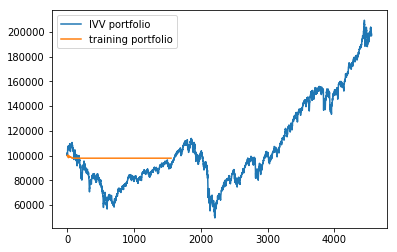

In [26]:
passive_port = df['close']*100000/port_test.loc[0,'close']
df_test_compare = pd.concat([passive_port, port_test['tot_value']],axis=1)
df_test_compare.rename(columns={'tot_value':'training portfolio','close':'IVV portfolio'},inplace=True)
df_test_compare.plot()

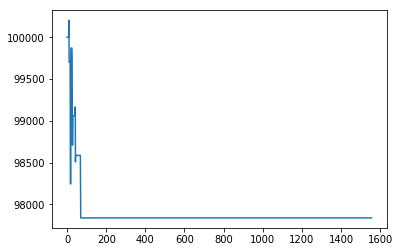

In [31]:
port_test['tot_value'].plot()

In [ ]:
#simple rule: if the predicted price of T+1 is certain percentage higher than the close of T, buy on T+1
#assumingly at the price of mean(open + close)
#assumptions: start at day 0 with $1000, can only buy integer shares of the IVV product
#if strong buy, buy as much as possible; if buy, buy half the maximum possible
def portfolio_exe(buy_level, strong_buy_level, sell_level, strong_sell_level, port_train):
    port_train['action_level'] =  
    


In [ ]:
X['close'].plot()

## Moving window prediction: use past 22 day, 66 day, 130 day, 252 day to make predictions

In [ ]:
class NeuralNetwork:
    def __init__(self, x, y):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1],4) 
        self.weights2   = np.random.rand(4,1)                 
        self.y          = y
        self.output     = np.zeros(y.shape)